In [1]:
1+1

2

In [2]:
import uproot
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
import matplotlib as mpl
import pickle
import h5py
import math

from util import *
import var
import cut
import data
import hist

import importlib

import pid
from pyanalib import panda_helpers
import os
import multiprocessing

from unc_funcs import *

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import subprocess


/exp/icarus/app/users/jdyer/dev_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib/python3.9/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.20.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[0.39431672 0.04210058 0.91800973]


In [3]:
from pyanalib import variable, histogram
from pyanalib.dataset import Dataset

importlib.reload(var)
importlib.reload(cut)
importlib.reload(data)
importlib.reload(hist)
importlib.reload(panda_helpers)
importlib.reload(variable)

<module 'pyanalib.variable' from '/exp/icarus/app/users/jdyer/dev_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/variable.py'>

In [4]:
mpl.rc('font', size=14)

dosave = False
savedir = "/exp/icarus/data/users/jdyer/muon_datamc/"


In [8]:
print(0.15*180/math.pi)
for i in [1.25, 2]:
    print(i*180/math.pi)
    
# IMPORTANT TO DO:
# - far sideband can't look at NuMI angles equal or smaller than 15 degrees to be in accordance with Gray's approved proposal.

# 

8.594366926962348
71.6197243913529
114.59155902616465


In [5]:
# Define Very Far Sideband

NuMI_angle_thresh = 15 # deg # Very Far Sideband I presented in 2023: > 0.15 rad # Use for selection: < 0.05 rad
open_angle_thresh = [1.25, 2]# Use for selection: < 0.35 rad 

def sb_numi_angle_mask(df, thresh = NuMI_angle_thresh): # do calculation in radians. User uses degrees.
    return df.Snumi_angle_mcs > thresh*math.pi/180., 'S_NuMI_angle > '+str(thresh)+' deg'#'\u00B0'

def sb_open_angle_mask(df, thresh = open_angle_thresh):
    return ( ( (np.arccos(dotdf(df.trunk.trk.dir, df.branch.trk.dir)) > thresh[0]*math.pi/180.) & 
            (np.arccos(dotdf(df.trunk.trk.dir, df.branch.trk.dir)) < thresh[1]*math.pi/180.) ), 
            str(thresh[0])+' rad < opening angle < '+str(thresh[1])+' deg')



In [6]:
def concat(self, *othrs, offset=0, sum_pot=True):
    if sum_pot:
        POT = sum([o.POT for o in othrs]) + self.POT # POT is total
    else:
        POT = min([o.POT for o in othrs] + [self.POT])

    livetime = sum([o.livetime for o in othrs]) + self.livetime

    for i in range(len(othrs)):
        othrs[i].df.index = othrs[i].df.index.set_levels(othrs[i].df.index.levels[0] + offset*(i+1), level=0)
        if self.hdrdf is not None:
            othrs[i].hdrdf.index = othrs[i].hdrdf.index.set_levels(othrs[i].hdrdf.index.levels[0] + offset*(i+1), level=0)

    df = pd.concat([self.df] + [o.df for o in othrs])
    
    # redo weights if not summing the pot
    if not sum_pot:
        df.loc[self.df.index, ("wgt", "cv", )] = self.df.wgt.cv*(POT/self.POT)
        for i in range(len(othrs)):
            df.loc[othrs[i].df.index, ("wgt", "cv", )] = othrs[i].df.wgt.cv*(POT/othrs[i].POT)
    
    hdrdf = None
    if self.hdrdf is not None:
        hdrdf = pd.concat([self.hdrdf] + [o.hdrdf for o in othrs])

    return Dataset(df, livetime, POT, hdrdf)


In [7]:
syst_labels = [
    "Middle Ind. Opaque",
    "Middle Ind. Transparent",
    "Front Ind. Gain Low",
    "Front Ind. Gain High",
    "Noise 1.2x"
]

In [8]:
nmu = var.DF.iscc & ((var.DF.pdg == 14) | (var.DF.pdg == -14))
npi = var.DF.npi
ns = var.DF.nsm + var.DF.nsp

is_coh_like = (nmu + npi + ns >= 2) & (var.DF.max_proton_ke < 0.05)

In [9]:
~is_coh_like

In [10]:
import gc
gc.collect() # What is this, and why is it different every time?

71

# Lighten datasets.
## Only Need to run once to save. Usually, can skip this section and instead go to "Start Here" section

## Input Files and functions

In [24]:
# These are all neutrinos. 

filedir = "/icarus/data/users/gputnam/DMCP2023G/"

mcfile = "/icarus/data/users/gputnam/DMCP2023G/mc/dfs-wstubs/mcnuphase2_evt_reprodD.df"
mccohfile = "/icarus/data/users/gputnam/DMCP2023G/mc/dfs-wstubs/coh-like-evt-CV.df"

mccoh_syst_files = [
    filedir + "mc/dfs-wstubs/coh-like-evt-ind1bin0.df",
    filedir + "mc/dfs-wstubs/coh-like-evt-ind1bin14.df",
    filedir + "mc/dfs-wstubs/coh-like-evt-ind0gainlo.df",
    filedir + "mc/dfs-wstubs/coh-like-evt-ind0gainhi.df",
    filedir + "mc/dfs-wstubs/coh-like-evt-noisehi.df"
] # These are like the other dataframes (not just stuff you concat to the event dataframes I have with one-to-one mapping)
print(syst_labels)

onbeamfile_Run1 = filedir + "data-reprod-D/dfs-wstubs/Run1OnBeamReprodD_evt.df"
onbeamfile_Run2 = filedir + "data-reprod-D/dfs-wstubs/Run2OnBeamReprodD_evt.df"

offbeamfile_Run1 = filedir + "data-reprod-D/dfs-wstubs/Run1OffBeamReprodD_evt.df"
offbeamfile_Run2 = filedir + "data-reprod-D/dfs-wstubs/Run2OffBeamReprodD_evt.df"

['Middle Ind. Opaque', 'Middle Ind. Transparent', 'Front Ind. Gain Low', 'Front Ind. Gain High', 'Noise 1.2x']


In [ ]:
def lighten_dataset(evt_dataframe, newcol_name=None, newcol_val=None): #, dataset_name, savedir # dataset
    #new_dataset = dataset#.copy()
    #df = dataset.df.copy()
    df = evt_dataframe.copy()
    print("At start: ", df.shape)
    
    # Require exiting:

    when_uncontained = ~TrkInFV(df.trunk.trk.end) | ~TrkInFV(df.branch.trk.end)
    df = df[when_uncontained]
    #print(when_uncontained)
    #print(when_uncontained[when_uncontained == False])
    print("Require exiting: ", df.shape)
    
    # add longer/shorter track length to evtdf:

    longer_track_length = []
    shorter_track_length = []
    trunk_len = np.array(df.trunk.trk.len)
    branch_len = np.array(df.branch.trk.len)
    for i in range(len(trunk_len)):
        longer_track_length.append(max([ trunk_len[i], branch_len[i] ]))
        shorter_track_length.append(min([ trunk_len[i], branch_len[i] ]))
    df["longer_track_length"] = longer_track_length
    df["shorter_track_length"] = shorter_track_length
    print("After track length ranks added: ", df.shape)
    
    # add Snumi_angle to evtdf:

    df["Snumi_angle_mcs"] = Sbeamangle(df.trunk.trk, df.branch.trk, BEAMDIR, 'mcs')
    print("After NuMI angle added: ", df.shape)
    
    # Restrict dataframe to sideband:
    
    sideband_mask = sb_numi_angle_mask(df)[0] & sb_open_angle_mask(df)[0]
    df = df[sideband_mask]
    print("After restriction to sideband: ", df.shape)
    
    # Add columns to dataframe as needed:
    
    if newcol_name is not None:
        for c, col_name in enumerate(newcol_name):
            df[col_name] = newcol_val[c]
        print("After adding other columns: ", df.shape)
        
    # Return lightened dataframe:
    
    return df

## MC Coh
Keys I do: evt, hdr, mch, mcnu

In [15]:
# test
f = h5py.File(mccohfile, 'r')
print(f.keys())

<KeysViewHDF5 ['evt', 'hdr', 'mch', 'mcnu']>


In [16]:
%%time 
# takes about 7 minutes to run.
mccoh = data.mc_dataset(mccohfile, "evt")
mccoh.df

GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnNC1pi
G

slc                          \
                              is_clear_cosmic      vertex               
                                                        x           y   
                                                                        
                                                                        
                                                                        
__ntuple entry rec.slc..index                                           
0        2     0                            0  230.599869  -87.065186   
         6     0                            0  252.052216  -19.807281   
         10    0                            0 -182.754028   98.460663   
         13    0                            0  276.464661 -124.106667   
         16    0                            0 -142.625778 -107.705841   
..                                        ...         ...         ...   
9971     37    0                            0 -136.405716 -149.124313   
         38    0                            0 -114.468658 -104.247482   
         41    0                            0  180.353149 -115.615089   
         42    0                            0 -227.696442 -142.229584   
         45    0                            0 -122.545059  -66.605896   

                                                                        \
                                          self    tmatch                 
                                        z            eff       pur idx   
                                                                         
                                                                         
                                                                         
__ntuple entry rec.slc..index                                            
0        2     0               463.770660    2  0.842924  1.000000   0   
         6     0               508.931946    5  0.838395  1.000001   0   
         10    0               215.438538   10  0.809702  1.000000   0   
         13    0               -15.830807    4  0.935376  1.000001   0   
         16    0              -579.156189    5  0.726626  1.000000   0   
..                                    ...  ...       ...       ...  ..   
9971     37    0                38.031872    8  0.916807  0.999999   0   
         38    0               127.925629    7  0.881981  1.000000   0   
         41    0               122.263573    6  0.820942  1.000000   0   
         42    0              -648.195740   18  0.464565  1.000000   0   
         45    0              -731.203369    7  0.768127  1.000001   0   

                                                      ...       wgt            \
                              producer          nuid  ...        g4             
                                       crlongtrkdiry  ...   univ_90   univ_91   
                                                      ...                       
                                                      ...                       
                                                      ...                       
__ntuple entry rec.slc..index                         ...                       
0        2     0                     1     -0.206118  ...  1.382173  1.245420   
         6     0                     1     -0.611813  ...  0.963807  1.166116   
         10    0                     0     -0.213754  ...  0.818418  1.051987   
         13    0                     1     -0.655443  ...  0.967488  1.013995   
         16    0                     0     -0.158669  ...  1.205915  0.880557   
..                                 ...           ...  ...       ...       ...   
9971     37    0                     0     -0.272064  ...  1.046338  1.074242   
         38    0                     0     -0.556795  ...  1.061857  0.859539   
         41    0                     1     -0.254742  ...  0.835383  0.975386   
         42    0                     0     -0.485313  ...  0.958500  0.953283   
         45    0 

In [17]:
mccohfile_evt = mccoh
mccohfile_evt_df = mccohfile_evt.df
print(mccohfile_evt_df.shape)

new_mccohfile_evt_df = lighten_dataset(mccohfile_evt_df)#, newcol_name=None, newcol_val=None)
print(new_mccohfile_evt_df.shape)

(231378, 643)
At start:  (231378, 643)
Require exiting:  (121452, 643)
After track length ranks added:  (121452, 645)
After NuMI angle added:  (121452, 646)
After restriction to sideband:  (25404, 646)
(25404, 646)


In [14]:
new_mccohfile_evt_df

slc                          \
                              is_clear_cosmic      vertex               
                                                        x           y   
                                                                        
                                                                        
                                                                        
__ntuple entry rec.slc..index                                           
0        16    0                            0 -142.625778 -107.705841   
         18    1                            0  210.450119 -158.881134   
2        32    0                            0 -332.216461   70.515289   
4        28    0                            0 -142.008743 -107.222946   
         30    0                            0 -191.230164 -105.129150   
..                                        ...         ...         ...   
9969     23    0                            0 -168.495071  102.280945   
         39    0                            0 -235.476471 -153.717896   
9970     42    0                            0 -124.278572   59.021210   
9971     18    0                            0  152.171616   11.456360   
         28    0                            0 -120.801758   94.887962   

                                                                        \
                                          self    tmatch                 
                                        z            eff       pur idx   
                                                                         
                                                                         
                                                                         
__ntuple entry rec.slc..index                                            
0        16    0              -579.156189    5  0.726626  1.000000   0   
         18    1              -647.312988    3  0.659301  1.000001   1   
2        32    0               390.109802    5  0.884572  1.000000   0   
4        28    0               228.063385    7  0.462621  1.000001   0   
         30    0               303.628693    7  0.861577  1.000002   0   
..                                    ...  ...       ...       ...  ..   
9969     23    0              -791.256287    6  0.812400  1.000000   0   
         39    0              -784.340515    7  0.682715  1.000001   0   
9970     42    0              -573.433350    3  0.759561  1.000001   0   
9971     18    0               354.118256    2  0.869114  1.000000   0   
         28    0              -116.958908    6  0.875392  1.000001   0   

                                                      ...       wgt            \
                              producer          nuid  ...        g4             
                                       crlongtrkdiry  ...   univ_93   univ_94   
                                                      ...                       
                                                      ...                       
                                                      ...                       
__ntuple entry rec.slc..index                         ...                       
0        16    0                     0     -0.158669  ...  0.576862  0.681345   
         18    1                     1     -0.108824  ...  1.599327  1.612172   
2        32    0                     0     -0.341418  ...  0.868668  0.944251   
4        28    0                     0     -0.001572  ...  1.279437  1.032912   
         30    0                     0     -0.266290  ...  0.756098  0.885294   
..                                 ...           ...  ...       ...       ...   
9969     23    0                     0      0.470950  ...  1.171733  0.565230   
         39    0                     0     -0.568567  ...  1.183570  0.936545   
9970     42    0                     0     -0.186683  ...  1.170038  1.149351   
9971     18    0                     1     -0.121474  ...  1.005211  1.127238   
         28    0 

In [19]:
%%time
mccohfile_hdr_df = pd.read_hdf(mccohfile, "hdr")

CPU times: user 257 ms, sys: 930 ms, total: 1.19 s
Wall time: 1.44 s


In [16]:
print(mccohfile_hdr_df)
mccohfile_hdr_df

pot first_in_subrun ismc run subrun ngenevt   evt  \
                                                                             
                                                                             
__ntuple entry                                                               
0        0      5.909483e+17               1    1   1      0    1000    20   
         1      0.000000e+00               0    1   1      0    1000    21   
         2      0.000000e+00               0    1   1      0    1000   102   
         3      0.000000e+00               0    1   1      0    1000   106   
         4      0.000000e+00               0    1   1      0    1000   162   
...                      ...             ...  ...  ..    ...     ...   ...   
9971     41     0.000000e+00               0    1   1      0    1000   941   
         42     0.000000e+00               0    1   1      0    1000   957   
         43     0.000000e+00               0    1   1      0    1000   962   
         44     0.000000e+00               0    1   1      0    1000   976   
         45     0.000000e+00               0    1   1      0    1000  1000   

               proc  cluster fno  ...       wgt                                \
                                  ...        g4                                 
                                  ...   univ_90   univ_91   univ_92   univ_93   
__ntuple entry                    ...                                           
0        0      123  5117475   0  ...  0.974033  0.986670  1.006820  1.010615   
         1      123  5117475   0  ...  1.123290  0.962899  1.341853  0.842229   
         2      123  5117475   0  ...  1.382173  1.245420  0.850775  0.957057   
         3      123  5117475   0  ...  2.615667  2.152409  0.714193  0.768501   
         4      123  5117475   0  ...  0.435596  0.646109  0.587806  1.393141   
...             ...      ...  ..  ...       ...       ...       ...       ...   
9971     41      99  5117475   0  ...  0.835383  0.975386  0.752485  1.226651   
         42      99  5117475   0  ...  0.958500  0.953283  0.984752  1.027322   
         43      99  5117475   0  ...  0.831292  0.938545  0.500837  1.077470   
         44      99  5117475   0  ...  0.975049  0.972891  0.991855  1.015580   
         45      99  5117475   0  ...  0.979400  1.199904  0.646637  1.121643   

                                                                            
                                                                            
                 univ_94   univ_95   univ_96   univ_97   univ_98   univ_99  
__ntuple entry                                                              
0        0      1.021456  0.992579  1.005164  0.976827  1.001447  0.987788  
         1      0.899107  0.705802  0.710628  0.829337  0.798733  0.895235  
         2      1.119884  0.719831  1.572813  1.288538  0.779288  1.081412  
         3      0.572950  0.554065  0.421326  1.336114  0.715422  1.007181  
         4      1.638117  2.125832  1.651031  0.878948  1.247578  0.868319  
...                  ...       ...       ...       ...       ...       ...  
9971     41     1.220798  1.251522  1.095079  1.024413  0.955627  1.055603  
         42     1.033074  1.030357  1.029431  0.979838  1.008840  0.987944  
         43     1.141882  1.599661  1.168185  1.351672  0.771446  1.182755  
         44     1.020146  1.015118  1.016461  0.986222  1.005972  0.990815  
         45     1.258012  1.063244  0.827730  1.003523  0.772008  0.905506  

[509758 rows x 418 columns]

Edit: No!! Don't place cuts on hdr dataframes!

Keep only the rows in hdr and mc dataframes for which '_ _ntuple' and 'entry' are in lightened evt dataframe.

https://stackoverflow.com/questions/70122203/pandas-multiindex-intersection-on-partial-levels


In [15]:
## NO!
#print(mccohfile_hdr_df.shape)
#lightened_hdr_df = mccohfile_hdr_df.loc[mccohfile_hdr_df.index.isin(new_mccohfile_evt_df.index.droplevel("rec.slc..index"))]
#print(lightened_hdr_df.shape)
#lightened_hdr_df


(509758, 418)
(25333, 418)


pot first_in_subrun ismc run subrun ngenevt  evt  \
                                                                            
                                                                            
__ntuple entry                                                              
0        16     0.000000e+00               0    1   1      0    1000  668   
         18     0.000000e+00               0    1   1      0    1000  694   
21       0      5.873271e+17               1    1   1      0    1000    4   
         7      0.000000e+00               0    1   1      0    1000  166   
6        12     0.000000e+00               0    1   1      0    1000  369   
...                      ...             ...  ...  ..    ...     ...  ...   
9969     23     0.000000e+00               0    1   1      0    1000  538   
         39     0.000000e+00               0    1   1      0    1000  827   
9970     42     0.000000e+00               0    1   1      0    1000  772   
9971     18     0.000000e+00               0    1   1      0    1000  548   
         28     0.000000e+00               0    1   1      0    1000  693   

               proc  cluster fno  ...       wgt                                \
                                  ...        g4                                 
                                  ...   univ_90   univ_91   univ_92   univ_93   
__ntuple entry                    ...                                           
0        16     123  5117475   0  ...  1.205915  0.880557  1.768609  0.576862   
         18     123  5117475   0  ...  0.932189  0.742845  0.925688  1.599327   
21       0      128  5117475   0  ...  1.277780  2.103579  0.179394  0.679223   
         7      128  5117475   0  ...  1.400687  1.312949  1.255729  0.930362   
6        12     496  5117475   0  ...  0.743763  0.822883  0.679883  0.983967   
...             ...      ...  ..  ...       ...       ...       ...       ...   
9969     23      97  5117475   0  ...  1.888204  0.685168  1.035955  1.171733   
         39      97  5117475   0  ...  1.146559  1.935707  0.889175  1.183570   
9970     42      98  5117475   0  ...  0.901276  1.051268  0.780510  1.170038   
9971     18      99  5117475   0  ...  1.303504  1.081159  0.939429  1.005211   
         28      99  5117475   0  ...  0.446407  0.496549  0.664379  0.726906   

                                                                            
                                                                            
                 univ_94   univ_95   univ_96   univ_97   univ_98   univ_99  
__ntuple entry                                                              
0        16     0.681345  0.554411  1.017841  0.837715  1.200166  0.774987  
         18     1.612172  1.041288  1.567565  0.851746  1.043746  0.962725  
21       0      0.604206  0.575941  0.676596  1.289122  0.466452  1.166078  
         7      0.645992  0.584450  0.658206  1.005365  1.025607  1.107907  
6        12     1.315500  1.281179  1.167175  0.954035  0.910424  0.768504  
...                  ...       ...       ...       ...       ...       ...  
9969     23     0.565230  0.654094  0.736090  0.889704  1.492059  0.975967  
         39     0.936545  0.863866  0.573068  1.281051  0.461242  1.837358  
9970     42     1.149351  1.179576  1.039250  1.054955  0.947368  1.079098  
9971     18     1.127238  0.895979  1.348369  1.110236  0.836258  1.001600  
         28     1.148228  2.641534  0.615834  1.055749  0.678996  0.614209  

[25333 rows x 418 columns]

In [20]:
%%time
mccohfile_mch_df = pd.read_hdf(mccohfile, "mch")
print(mccohfile_mch_df.shape)

(0, 18)
CPU times: user 37.1 ms, sys: 13.3 ms, total: 50.5 ms
Wall time: 56.8 ms


In [17]:
## Don't need to index-match for mch dataframe, because it has shape 0.
#lightened_mccohfile_mch_df = mccohfile_mch_df.loc[mccohfile_mch_df.index.isin(new_mccohfile_evt_df.index.droplevel("rec.slc..index"))]
#print(lightened_mccohfile_mch_df.shape)

ValueError: Length of names must match number of levels in MultiIndex.

In [21]:
%%time
mccohfile_mcnu_df = pd.read_hdf(mccohfile, "mcnu")
print(mccohfile_mcnu_df.shape)

(618481, 1698)
CPU times: user 26.7 s, sys: 24.3 s, total: 51 s
Wall time: 1min 29s


In [19]:
mccohfile_mcnu_df

E  bjorkenX inelasticityY        Q2  \
                                                                              
                                                                              
__ntuple entry rec.mc.nu..index                                               
0        0     0                 1.492798  0.056557      0.265005  0.042015   
         1     0                 1.454162  0.207199      0.911862  0.515926   
         2     0                 2.541240  0.300635      0.222422  0.319096   
         3     0                 4.296767  0.323207      0.683468  1.782372   
         4     0                 2.726789  0.146705      0.913355  0.686112   
...                                   ...       ...           ...       ...   
9971     41    0                 1.899026  0.452091      0.328913  0.530268   
         42    0                 3.144160  0.394771      0.643958  1.500946   
         43    0                 0.663765  0.055328      0.570156  0.039319   
         44    0                 0.564101  0.149325      0.762612  0.120629   
         45    0                 2.658459  0.380765      0.684407  1.300946   

                                        w   t    position              \
                                                        x           y   
                                                                        
__ntuple entry rec.mc.nu..index                                         
0        0     0                 1.257944 NaN -195.550537  -51.121754   
         1     0                 1.689866 NaN -118.737709  -18.578798   
         2     0                 1.274314 NaN  231.064087  -87.338921   
         3     0                 2.147986 NaN -123.834839 -107.462547   
         4     0                 2.207319 NaN -194.804733 -144.463165   
...                                   ...  ..         ...         ...   
9971     41    0                 1.234595 NaN  179.013428 -116.272331   
         42    0                 1.784011 NaN -227.539688 -171.342392   
         43    0                 1.246160 NaN  189.043289   88.661507   
         44    0                 1.252505 NaN -211.066589  -92.196419   
         45    0                 1.731268 NaN -121.772285  -66.624107   

                                            pdg  ...       wgt            \
                                          z      ...        g4             
                                                 ...   univ_90   univ_91   
__ntuple entry rec.mc.nu..index                  ...                       
0        0     0                -317.795898  14  ...  0.974033  0.986670   
         1     0                -135.774597  14  ...  1.123290  0.962899   
         2     0                 463.727264 -14  ...  1.382173  1.245420   
         3     0                -279.465485  14  ...  2.615667  2.152409   
         4     0                 183.190536  14  ...  0.435596  0.646109   
...                                     ...  ..  ...       ...       ...   
9971     41    0                 121.869507  14  ...  0.835383  0.975386   
         42    0                -692.403931  14  ...  0.958500  0.953283   
         43    0                -684.529114  14  ...  0.831292  0.938545   
         44    0                 205.406281  14  ...  0.975049  0.972891   
         45    0                -731.371277  14  ...  0.979400  1.199904   

                                                                         \
                                                                          
                                  univ_92   univ_93   univ_94   univ_95   
__ntuple entry rec.mc.nu..index                                           
0        0     0                 1.006820  1.010615  1.021456  0.992579   
         1     0                 1.341853  0.842229  0.899107  0.705802   
         2     0                 0.850775  0.957057  1.119884  0.719831   
         3     0                 0.714193  0.768501  0.572950  0.554065   
         4     0 

In [22]:
print(savedir)

/icarus/data/users/jdyer/muon_datamc/


In [23]:
# resave dataset with lightened evt dataframe:

df_names = ['evt', 'hdr', 'mch', 'mcnu']
mccoh_dfs = [new_mccohfile_evt_df, mccohfile_hdr_df, mccohfile_mch_df, mccohfile_mcnu_df]

output = savedir+'lightened/mccoh'
with pd.HDFStore(output) as hdf:
    for k,df in zip(df_names, mccoh_dfs):
        try:
            hdf.put(key=k, value=df, format="fixed")
        except Exception as e:
            print("Table %s failed to save, skipping. Exception: %s" % (k, str(e)))
    
    


/exp/icarus/app/users/jdyer/dev_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/exp/icarus/app/users/jdyer/dev_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.mc.prtl..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/exp/icarus/app/users/jdyer/dev_sbnana_v09_69_01/src

In [24]:
# Now try extracting from what I saved above:

myfile = savedir+'lightened/mccoh'
extract_evt_df = pd.read_hdf(myfile, key="evt")
print(extract_evt_df.shape)
extract_hdr_df = pd.read_hdf(myfile, key="hdr")
print(extract_hdr_df.shape)
extract_mch_df = pd.read_hdf(myfile, key="mch")
print(extract_mch_df.shape)
extract_mcnu_df = pd.read_hdf(myfile, key="mcnu")
print(extract_mcnu_df.shape)


(25404, 646)
(509758, 17)
(0, 18)
(618481, 1698)


## MC Incoh
Keys I do: evt, hdr

In [33]:
# test
f = h5py.File(mcfile, 'r')
print(f.keys())



<KeysViewHDF5 ['evt', 'hdr', 'mch', 'mcnu']>


In [26]:
%%time
# takes about 23 minutes to run.
mc_incoh_evt = data.mc_dataset(mcfile, "evt", mccut=~is_coh_like, mccut_any=False)
mc_incoh_evt_df = mc_incoh_evt.df


KeyboardInterrupt: 

In [15]:
print(mc_incoh_evt_df.shape)
lightened_mc_incoh_evt_df = lighten_dataset(mc_incoh_evt_df)#, newcol_name=None, newcol_val=None)
print(lightened_mc_incoh_evt_df.shape)
lightened_mc_incoh_evt_df.to_pickle(savedir + 'lightened/dataframes/new_mc_incoh_evt_df')

(354253, 644)
At start:  (354253, 644)
Require exiting:  (207077, 644)
After track length ranks added:  (207077, 646)
After NuMI angle added:  (207077, 647)
After restriction to sideband:  (33009, 647)
(33009, 647)


In [28]:
# If I've already made the dataframe and pickled it, then read it in here:
lightened_mc_incoh_evt_df = pd.read_pickle(savedir + 'lightened/dataframes/new_mc_incoh_evt_df')

In [16]:
lightened_mc_incoh_evt_df

slc                          \
                              is_clear_cosmic      vertex               
                                                        x           y   
                                                                        
                                                                        
                                                                        
__ntuple entry rec.slc..index                                           
0        227   16                           0  259.517456  -75.337036   
1        40    25                           0  261.326172  -62.111523   
         113   0                            0  -99.813812  -23.219299   
         131   0                            0 -273.093964 -128.750549   
2        153   1                            0 -247.732452   63.845123   
..                                        ...         ...         ...   
7002     135   16                           0  212.722839  -23.101929   
         162   1                            0 -140.100677  -16.268158   
               15                           0  183.212860  -64.264679   
         229   1                            0 -277.766785  -36.117310   
         234   16                           0  340.450500  -13.947693   

                                                                         \
                                          self    tmatch                  
                                        z            eff       pur  idx   
                                                                          
                                                                          
                                                                          
__ntuple entry rec.slc..index                                             
0        227   16             -643.179626   99       NaN       NaN -999   
1        40    25             -103.098274  107  0.818190  0.991477    0   
         113   0               653.665894  196  0.899666  0.993640    0   
         131   0              -726.507019  184       NaN       NaN -999   
2        153   1              -199.585922   86  0.862850  0.999916    0   
..                                    ...  ...       ...       ...  ...   
7002     135   16             -709.088562  205       NaN       NaN -999   
         162   1               -59.770523  136       NaN       NaN -999   
               15             -431.521973  161  0.843747  0.974162    0   
         229   1               774.510376  164  0.782471  0.995421    0   
         234   16             -540.728577  259       NaN       NaN -999   

                                                      ...       wgt            \
                              producer          nuid  ...        g4             
                                       crlongtrkdiry  ...   univ_93   univ_94   
                                                      ...                       
                                                      ...                       
                                                      ...                       
__ntuple entry rec.slc..index                         ...                       
0        227   16                    1     -0.914205  ...  1.003435  1.003652   
1        40    25                    1     -0.279710  ...  1.013674  1.204723   
         113   0                     0     -0.681174  ...  1.240644  1.176385   
         131   0                     0     -0.958456  ...  1.111578  0.833646   
2        153   1                     0     -0.378915  ...  1.066350  1.131473   
..                                 ...           ...  ...       ...       ...   
7002     135   16                    1     -0.954728  ...  0.804309  1.325901   
         162   1                     0     -0.961950  ...  1.197447  0.693049   
               15                    1     -0.448731  ...  1.197447  0.693049   
         229   1                     0     -0.065956  ...  1.007433  1.010126   

In [25]:
mc_incoh_hdr_df = pd.read_hdf(mcfile, "hdr")
print(mc_incoh_hdr_df.shape)
mc_incoh_mch_df = pd.read_hdf(mcfile, "mch")
print(mc_incoh_mch_df.shape)
#mc_incoh_mcnu_df = pd.read_hdf(mcfile, "mcnu") # memory issue.
#print(mc_incoh_mcnu_df.shape)

(2092170, 17)
(0, 18)


In [28]:
# Read in individual dataframes from pickles:

lightened_mc_incoh_evt_df = pd.read_pickle(savedir + 'lightened/dataframes/new_mc_incoh_evt_df')
#lightened_mc_incoh_hdr_df = pd.read_pickle(savedir + 'lightened/dataframes/lightened_mc_incoh_hdr_df')
#mc_incoh_mch_df = pd.read_pickle(savedir + 'lightened/dataframes/mc_incoh_mch_df')
#lightened_mc_incoh_mcnu_df = pd.read_pickle(savedir + 'lightened/dataframes/lightened_mc_incoh_mcnu_df')


In [32]:
# resave lightened mc_incoh stuff:

df_names = ['evt', 'hdr']# 'mch']#, 'mcnu']
mc_incoh_dfs = [lightened_mc_incoh_evt_df, mc_incoh_hdr_df]#, lightened_mc_incoh_mcnu_df]

output = savedir+'lightened/mc_incoh'
with pd.HDFStore(output) as hdf:
    for k,df in zip(df_names, mc_incoh_dfs):
        print(k)
        try:
            hdf.put(key=k, value=df, format="fixed")
        except Exception as e:
            print("Table %s failed to save, skipping. Exception: %s" % (k, str(e)))
    
    

evt
hdr


## Systematics (for Coh-like events)
Keys I do: evt, hdr

In [15]:
#For reference (delete later):

for thing in mccoh_syst_files:
    print(thing)
print('\n')
for label in syst_labels:
    print(label)

/icarus/data/users/gputnam/DMCP2023G/mc/dfs-wstubs/coh-like-evt-ind1bin0.df
/icarus/data/users/gputnam/DMCP2023G/mc/dfs-wstubs/coh-like-evt-ind1bin14.df
/icarus/data/users/gputnam/DMCP2023G/mc/dfs-wstubs/coh-like-evt-ind0gainlo.df
/icarus/data/users/gputnam/DMCP2023G/mc/dfs-wstubs/coh-like-evt-ind0gainhi.df
/icarus/data/users/gputnam/DMCP2023G/mc/dfs-wstubs/coh-like-evt-noisehi.df


Middle Ind. Opaque
Middle Ind. Transparent
Front Ind. Gain Low
Front Ind. Gain High
Noise 1.2x


In [40]:
%%time
for i, systFile in enumerate(mccoh_syst_files):
    #f = h5py.File(systFile, 'r')
    #print(f.keys(), '\n')
    evt = data.mc_dataset(systFile, "evt")
    evt_df = evt.df
    print(evt_df.shape)
    lightened_evt_df = lighten_dataset(evt_df)#, newcol_name=None, newcol_val=None)
    print(lightened_evt_df.shape)
    lightened_evt_df.to_pickle(savedir + 'lightened/dataframes/syst_mccoh_evt_df_'+syst_labels[i])

GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1eta
GENIEReWeight_ICARUS_v2_multisigma_Theta_Delta2Npi
GENIEReWeight_ICARUS_v2_multisigma_ThetaDelta2NRad
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvpNC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC1pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnCC2pi
GENIEReWeight_ICARUS_v2_multisigma_NonRESBGvnNC1pi
G

beam_div
beam_shift_x
beam_spot
horn1_x
horn1_y
horn_current_plus
water_layer
pca0
pca1
pca2
pca3
pca4
pca5
pca6
pca7
pca8
pca9
pca10
pca11
pca12
pca13
pca14
pca15
pca16
pca17
pca18
pca19
reinteractions_piminus_Geant4
reinteractions_piplus_Geant4
reinteractions_proton_Geant4
(236220, 643)
At start:  (236220, 643)
Require exiting:  (124823, 643)
After track length ranks added:  (124823, 645)
After NuMI angle added:  (124823, 646)
After restriction to sideband:  (26302, 646)
(26302, 646)
GENIEReWeight_ICARUS_v2_multisigma_VecFFCCQEshape
GENIEReWeight_ICARUS_v2_multisigma_RPA_CCQE
GENIEReWeight_ICARUS_v2_multisigma_CoulombCCQE
GENIEReWeight_ICARUS_v2_multisim_ZExpAVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_NormCCMEC
GENIEReWeight_ICARUS_v2_multisigma_NormNCMEC
GENIEReWeight_ICARUS_v2_multisigma_DecayAngMEC
GENIEReWeight_ICARUS_v2_multisim_CCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisim_NCRESVariationResponse
GENIEReWeight_ICARUS_v2_multisigma_RDecBR1gamma
GENIEReWeight_I

KeyboardInterrupt: 

In [18]:
syst_evt_dfs_list = []
for label in syst_labels:
    syst_evt_dfs_list.append(pd.read_pickle(savedir + 'lightened/dataframes/syst_mccoh_evt_df_'+label))
print(len(syst_evt_dfs_list))

5


In [19]:
for i, systFile in enumerate(mccoh_syst_files):
    #pd.read_pickle(savedir + 'lightened/dataframes/new_mc_incoh_evt_df')
    #hdr = data.mc_dataset(systFile, "hdr")
    hdr_df = pd.read_hdf(systFile, "hdr")
    print(hdr_df.shape)
    hdr_df.to_pickle(savedir + 'lightened/dataframes/syst_mccoh_hdr_df_'+syst_labels[i])
    

(510363, 17)
(510349, 17)
(509869, 17)
(510123, 17)
(510264, 17)


In [20]:
syst_hdr_dfs_list = []
for label in syst_labels:
    syst_hdr_dfs_list.append(pd.read_pickle(savedir + 'lightened/dataframes/syst_mccoh_hdr_df_'+label))
print(len(syst_hdr_dfs_list))

5


In [21]:
for i, systFile in enumerate(mccoh_syst_files):
    mcnu_df = pd.read_hdf(systFile, "mcnu")
    print(mcnu_df.shape)
    hdr_df.to_pickle(savedir + 'lightened/dataframes/syst_mccoh_mcnu_df_'+syst_labels[i])

syst_mcnu_dfs_list = []
for label in syst_labels:
    syst_mcnu_dfs_list.append(pd.read_pickle(savedir + 'lightened/dataframes/syst_mccoh_mcnu_df_'+label))
print(len(syst_mcnu_dfs_list))

(619204, 1698)
(619181, 1698)
(618584, 1698)
(618881, 1698)


OSError: [Errno 122] Disk quota exceeded

In [38]:
# resave lightened syst stuff:

#key_names = [, 'hdr']#, 'mch', 'mcnu']
dataset_names = [
    "coh-like-evt-ind1bin0",
    "coh-like-evt-ind1bin14",
    "coh-like-evt-ind0gainlo",
    "coh-like-evt-ind0gainhi",
    "coh-like-evt-noisehi"
]

for i, syst in enumerate(dataset_names):
    print(syst)
    output = savedir+'lightened/syst_'+syst
    try: 
        subprocess.run(['rm', output])
    except:
        print("Did not delete pre-existing file.")
    with pd.HDFStore(output) as hdf:
        try:
            hdf.put(key='evt', value=syst_evt_dfs_list[i], format="fixed")
        except Exception as e:
            print("Table %s failed to save, skipping. Exception: %s" % ('evt', str(e)))
            
        try:
            hdf.put(key='hdr', value=syst_hdr_dfs_list[i], format="fixed")
            #hdf.put(key='mcnu', value=syst_mcnu_dfs_list[i], format="fixed")
        except Exception as e:
            print("Table %s failed to save, skipping. Exception: %s" % ('hdr', str(e)))
        


coh-like-evt-ind1bin0


/exp/icarus/app/users/jdyer/dev_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Table hdr failed to save, skipping. Exception: Problems creating the Array.
coh-like-evt-ind1bin14


HDF5ExtError: HDF5 error back trace

  File "H5F.c", line 532, in H5Fcreate
    unable to create file
  File "H5VLcallback.c", line 3282, in H5VL_file_create
    file create failed
  File "H5VLcallback.c", line 3248, in H5VL__file_create
    file create failed
  File "H5VLnative_file.c", line 63, in H5VL__native_file_create
    unable to create file
  File "H5Fint.c", line 2112, in H5F_open
    problems closing file
  File "H5Fint.c", line 1574, in H5F__dest
    problems closing file
  File "H5Faccum.c", line 1072, in H5F__accum_reset
    can't flush metadata accumulator
  File "H5Faccum.c", line 1037, in H5F__accum_flush
    file write failed
  File "H5FDint.c", line 240, in H5FD_write
    driver write request failed
  File "H5FDsec2.c", line 864, in H5FD__sec2_write
    file write failed: time = Wed Jan 10 11:25:17 2024
, filename = '/exp/icarus/data/users/jdyer/muon_datamc/lightened/syst_coh-like-evt-ind1bin14', file descriptor = 59, errno = 122, error message = 'Disk quota exceeded', buf = 0x14a73d68, total write size = 800, bytes this sub-write = 800, bytes actually written = 18446744073709551615, offset = 0
  File "H5Fint.c", line 2076, in H5F_open
    unable to flush superblock
  File "H5Fio.c", line 267, in H5F_flush_tagged_metadata
    can't reset accumulator
  File "H5Faccum.c", line 1072, in H5F__accum_reset
    can't flush metadata accumulator
  File "H5Faccum.c", line 1037, in H5F__accum_flush
    file write failed
  File "H5FDint.c", line 240, in H5FD_write
    driver write request failed
  File "H5FDsec2.c", line 864, in H5FD__sec2_write
    file write failed: time = Wed Jan 10 11:25:17 2024
, filename = '/exp/icarus/data/users/jdyer/muon_datamc/lightened/syst_coh-like-evt-ind1bin14', file descriptor = 59, errno = 122, error message = 'Disk quota exceeded', buf = 0x614b538, total write size = 96, bytes this sub-write = 96, bytes actually written = 18446744073709551615, offset = 0

End of HDF5 error back trace

Unable to open/create file '/exp/icarus/data/users/jdyer/muon_datamc/lightened/syst_coh-like-evt-ind1bin14'

## Data
Keys I do: evt, hdr

### Onbeam

In [39]:
#test
f = h5py.File(onbeamfile_Run1, 'r')
print(f.keys(), '\n')

<KeysViewHDF5 ['evt', 'hdr', 'mch', 'mcnu']> 



In [40]:
%%time

onbeamR1_evt = data.onbeam_dataset(onbeamfile_Run1, "evt")
onbeamR2_evt = data.onbeam_dataset(onbeamfile_Run2, "evt")

onbeamR1_evt_df = onbeamR1_evt.df
onbeamR2_evt_df = onbeamR2_evt.df

print(onbeamR1_evt_df.shape)

(36247, 208)
CPU times: user 12.3 s, sys: 3.09 s, total: 15.4 s
Wall time: 24.6 s


In [43]:
print(onbeamR1_evt_df.shape)
new_onbeamR1_evt_df = lighten_dataset(onbeamR1_evt_df)
new_onbeamR1_evt_df["Run1"] = True
new_onbeamR1_evt_df["Run2"] = False
print(new_onbeamR1_evt_df.shape)
new_onbeamR1_evt_df.to_pickle(savedir + 'lightened/dataframes/onbeamR1_evt_df')
print('\n')

print(onbeamR2_evt_df.shape)
new_onbeamR2_evt_df = lighten_dataset(onbeamR2_evt_df)
new_onbeamR2_evt_df["Run1"] = False
new_onbeamR2_evt_df["Run2"] = True
print(new_onbeamR2_evt_df.shape)
new_onbeamR2_evt_df.to_pickle(savedir + 'lightened/dataframes/onbeamR2_evt_df')

(36247, 208)
At start:  (36247, 208)
Require exiting:  (23023, 208)
After track length ranks added:  (23023, 210)
After NuMI angle added:  (23023, 211)
After restriction to sideband:  (3045, 211)
(3045, 213)


(149142, 208)
At start:  (149142, 208)
Require exiting:  (95678, 208)
After track length ranks added:  (95678, 210)
After NuMI angle added:  (95678, 211)
After restriction to sideband:  (13190, 211)
(13190, 213)


/exp/icarus/app/users/jdyer/dev_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [44]:
onbeamR1_hdr_df = pd.read_hdf(onbeamfile_Run1, "hdr")
onbeamR2_hdr_df = pd.read_hdf(onbeamfile_Run2, "hdr")

In [45]:
# resave lightened data dataset:

output = savedir+'lightened/onbeamR1'
with pd.HDFStore(output) as hdf:
    try:
        hdf.put(key='evt', value=new_onbeamR1_evt_df, format="fixed")
        hdf.put(key='hdr', value=onbeamR1_hdr_df, format="fixed")
    except Exception as e:
        print("exception occurred - need to investigate.")
        
output = savedir+'lightened/onbeamR2'
with pd.HDFStore(output) as hdf:
    try:
        hdf.put(key='evt', value=new_onbeamR2_evt_df, format="fixed")
        hdf.put(key='hdr', value=onbeamR2_hdr_df, format="fixed")
    except Exception as e:
        print("exception occurred - need to investigate.")
    

/exp/icarus/app/users/jdyer/dev_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


### Offbeam

In [48]:
%%time

offbeamR1_evt = data.offbeam_dataset(offbeamfile_Run1, "evt")
offbeamR2_evt = data.offbeam_dataset(offbeamfile_Run2, "evt")

offbeamR1_evt_df = offbeamR1_evt.df
offbeamR2_evt_df = offbeamR2_evt.df

print(offbeamR1_evt_df.shape)
print(offbeamR2_evt_df.shape)

(10914, 208)
(80655, 208)
CPU times: user 7.1 s, sys: 898 ms, total: 8 s
Wall time: 13 s


In [50]:
print(onbeamR1_evt_df.shape)
new_offbeamR1_evt_df = lighten_dataset(offbeamR1_evt_df)
new_offbeamR1_evt_df["Run1"] = True
new_offbeamR1_evt_df["Run2"] = False
print(new_offbeamR1_evt_df.shape)
#new_offbeamR1_evt_df.to_pickle(savedir + 'lightened/dataframes/offbeamR1_evt_df')
print('\n')

print(offbeamR2_evt_df.shape)
new_offbeamR2_evt_df = lighten_dataset(offbeamR2_evt_df)
new_offbeamR2_evt_df["Run1"] = False
new_offbeamR2_evt_df["Run2"] = True
print(new_offbeamR2_evt_df.shape)
#new_offbeamR2_evt_df.to_pickle(savedir + 'lightened/dataframes/offbeamR2_evt_df')

(36247, 208)
At start:  (10914, 208)
Require exiting:  (7297, 208)
After track length ranks added:  (7297, 210)
After NuMI angle added:  (7297, 211)
After restriction to sideband:  (805, 211)
(805, 213)


(80655, 208)
At start:  (80655, 208)
Require exiting:  (54792, 208)
After track length ranks added:  (54792, 210)
After NuMI angle added:  (54792, 211)
After restriction to sideband:  (6331, 211)
(6331, 213)


In [51]:
offbeamR1_hdr_df = pd.read_hdf(offbeamfile_Run1, "hdr")
offbeamR2_hdr_df = pd.read_hdf(offbeamfile_Run2, "hdr")

In [52]:
# resave lightened data dataset:

output = savedir+'lightened/offbeamR1'
with pd.HDFStore(output) as hdf:
    try:
        hdf.put(key='evt', value=new_offbeamR1_evt_df, format="fixed")
        hdf.put(key='hdr', value=offbeamR1_hdr_df, format="fixed")
    except Exception as e:
        print("exception occurred - need to investigate.")
        
output = savedir+'lightened/offbeamR2'
with pd.HDFStore(output) as hdf:
    try:
        hdf.put(key='evt', value=new_offbeamR2_evt_df, format="fixed")
        hdf.put(key='hdr', value=offbeamR2_hdr_df, format="fixed")
    except Exception as e:
        print("exception occurred - need to investigate.")

/exp/icarus/app/users/jdyer/dev_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib/python3.9/site-packages/tables/attributeset.py:459: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_namerec.slc..index'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


# Start Here

Note: The Sideband I had defined prior to January 11, which I made the lightened dataframes with, included too-small of NuMI angles to be in compliance with what Gray got approved. 
So, I need to make sure I mask those out here too, until I've rerun the "lighten" stuff with the updated sideband.

In [11]:
print(syst_labels)

['Middle Ind. Opaque', 'Middle Ind. Transparent', 'Front Ind. Gain Low', 'Front Ind. Gain High', 'Noise 1.2x']


In [12]:
filedir = "/exp/icarus/data/users/jdyer/muon_datamc/lightened/"

print(h5py.File(filedir + "mc_incoh", 'r').keys())
mc_inccoh_evt = pd.read_hdf(filedir + "mc_incoh", "evt")
mc_inccoh_evt = mc_inccoh_evt[mc_inccoh_evt.Snumi_angle_mcs > 15*math.pi/180.]
mc_inccoh_evt = pd.read_hdf(filedir + "mc_incoh", "hdr")

print(h5py.File(filedir + "mccoh", 'r').keys())
mccoh_evt = pd.read_hdf(filedir + "mccoh", "evt")
mccoh_evt = mccoh_evt[mccoh_evt.Snumi_angle_mcs > 15*math.pi/180.]
mccoh_hdr = pd.read_hdf(filedir + "mccoh", "hdr")

# TO DO: insert systs

print(h5py.File(filedir + "onbeamR1", 'r').keys())
onbeamR1_evt = pd.read_hdf(filedir + "onbeamR1", "evt")
onbeamR1_evt = onbeamR1_evt[onbeamR1_evt.Snumi_angle_mcs > 15*math.pi/180.]
onbeamR1_hdr = pd.read_hdf(filedir + "onbeamR1", "hdr")

print(h5py.File(filedir + "onbeamR2", 'r').keys())
onbeamR2_evt = pd.read_hdf(filedir + "onbeamR2", "evt")
onbeamR2_evt = onbeamR2_evt[onbeamR2_evt.Snumi_angle_mcs > 15*math.pi/180.]
onbeamR2_hdr = pd.read_hdf(filedir + "onbeamR2", "hdr")

print(h5py.File(filedir + "offbeamR1", 'r').keys())
offbeamR1_evt = pd.read_hdf(filedir + "offbeamR1", "evt")
offbeamR1_evt = offbeamR1_evt[offbeamR1_evt.Snumi_angle_mcs > 15*math.pi/180.]
offbeamR1_hdr = pd.read_hdf(filedir + "offbeamR1", "hdr")

print(h5py.File(filedir + "offbeamR2", 'r').keys())
offbeamR2_evt = pd.read_hdf(filedir + "offbeamR2", "evt")
offbeamR2_evt= offbeamR2_evt[offbeamR2_evt.Snumi_angle_mcs > 15*math.pi/180.]
offbeamR2_hdr = pd.read_hdf(filedir + "offbeamR2", "hdr")

<KeysViewHDF5 ['evt', 'hdr']>
<KeysViewHDF5 ['evt', 'hdr', 'mch', 'mcnu']>
<KeysViewHDF5 ['evt', 'hdr']>
<KeysViewHDF5 ['evt', 'hdr']>
<KeysViewHDF5 ['evt', 'hdr']>
<KeysViewHDF5 ['evt', 'hdr']>


In [35]:
for c in mccoh_evt.columns:
    print(c)

('slc', 'is_clear_cosmic', '', '', '', '')
('slc', 'vertex', 'x', '', '', '')
('slc', 'vertex', 'y', '', '', '')
('slc', 'vertex', 'z', '', '', '')
('slc', 'self', '', '', '', '')
('slc', 'tmatch', 'eff', '', '', '')
('slc', 'tmatch', 'pur', '', '', '')
('slc', 'tmatch', 'idx', '', '', '')
('slc', 'producer', '', '', '', '')
('slc', 'nuid', 'crlongtrkdiry', '', '', '')
('slc', 'truth', 'E', '', '', '')
('slc', 'truth', 'bjorkenX', '', '', '')
('slc', 'truth', 'inelasticityY', '', '', '')
('slc', 'truth', 'Q2', '', '', '')
('slc', 'truth', 'w', '', '', '')
('slc', 'truth', 't', '', '', '')
('slc', 'truth', 'position', 'x', '', '')
('slc', 'truth', 'position', 'y', '', '')
('slc', 'truth', 'position', 'z', '', '')
('slc', 'truth', 'pdg', '', '', '')
('slc', 'truth', 'iscc', '', '', '')
('slc', 'truth', 'genie_mode', '', '', '')
('slc', 'truth', 'max_proton_ke', '', '', '')
('slc', 'truth', 'nn', '', '', '')
('slc', 'truth', 'np', '', '', '')
('slc', 'truth', 'npi', '', '', '')
('slc', 't

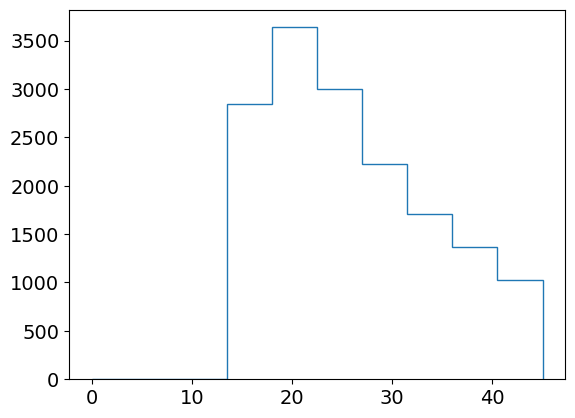

In [47]:
plt.hist(mccoh_evt.Snumi_angle_mcs*180./math.pi, histtype='step', range=(0,45.))
plt.show()